c:\Users\anton\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


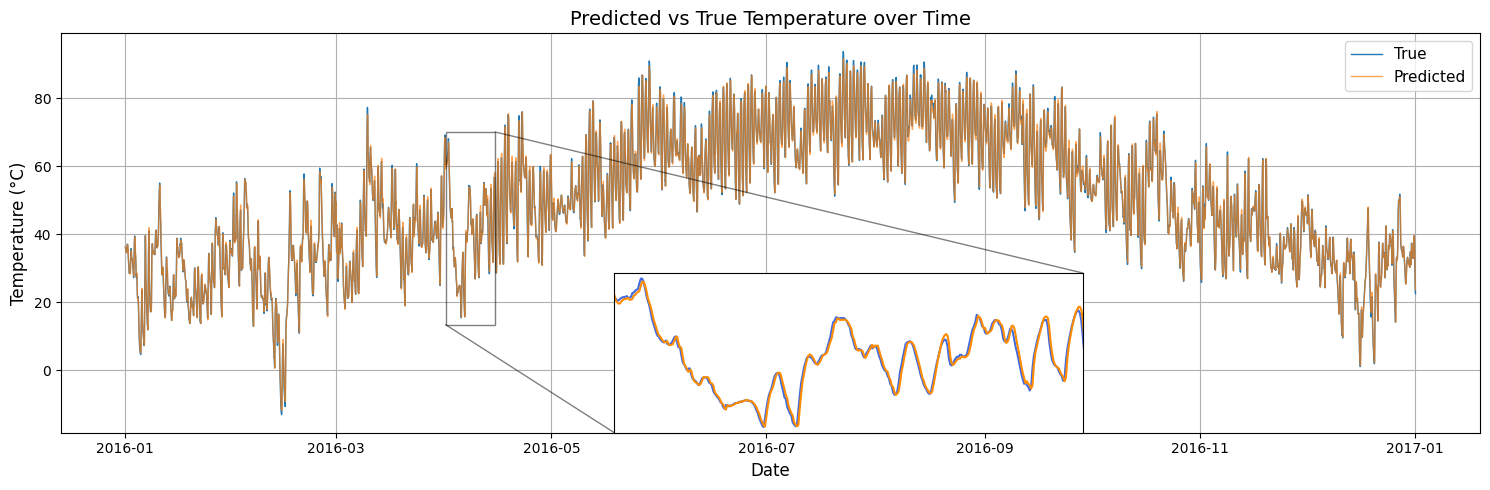

In [6]:
# === IMPORTS ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from keras.optimizers import Adam
from src.data.data_handler import DataHandler         # Custom data handler class
from src.models.lstm_model import LSTMModel           # Custom LSTM model class
from matplotlib.dates import DateFormatter
from matplotlib import rcParams

# === CONFIGURATION ===
# Define experiment name and paths for model, scaler, and data
exp_name = 'lstm_temp_1_24_lags_pressure_humidity'
base_dir = f'D:/Data science/energy-forecasting-ml/outputs/experiments_UMass/temp/{exp_name}'
checkpoint_path = os.path.join(base_dir, 'checkpoints', 'best_lstm_model.keras')
scaler_path     = os.path.join(base_dir, 'metrics', 'y_scaler.pkl')
csv_path        = 'D:/Data science/energy-forecasting-ml/data/processed/UMass Smart Dataset/weather_lag.csv'

# === LOAD DATA ===
# Initialize data handler for sequence and static features
dh = DataHandler(
    csv_path      = csv_path,
    date_col      = 'time',
    feature_cols  = ['temperature_lag_1', 'temperature_lag_24', 'pressure', 'humidity'],
    target_col    = 'temperature',
    no_scale_cols = [],
    holdout_years = 1,
    scaler_type   = 'standard'
)

# Load full dataset and split into train/val and test sets
df_all = dh.load_data()
df_trainval, df_test = dh.temporal_split(df_all)

# Save test set dates for plotting (before the column is dropped later)
test_dates = df_test[dh.date_col].reset_index(drop=True)

# Extract sequential and static input arrays and targets
X_seq_tr, X_stat_tr, y_tr, X_seq_val, X_stat_val, y_val, X_seq_te, X_stat_te, y_te = \
    dh.get_sequence_data(val_years=1)

# Prepare input dictionary for testing
X_test_dict = {
    'seq_input': X_seq_te,
    'static_input': X_stat_te
}

# === MODEL RECONSTRUCTION ===
# Set model architecture and training parameters (used for consistency)
params = {
    'input_shape_seq': X_seq_te.shape[1:],       # Shape of sequence input
    'input_shape_stat': X_stat_te.shape[1],      # Shape of static input
    'lstm_units': 64,
    'dense_units': 128,
    'optimizer': Adam(learning_rate=1e-4),
    'loss': 'mse',
    'metrics': ['mae'],
    'epochs': 200,
    'batch_size': 32,
    'early_stop_patience': 10,
    'checkpoint_path': checkpoint_path,
    'scale_y': True,
    'verbose': 1,
    'scale_mode': 'standard',
}

# Instantiate the model and load trained weights
model = LSTMModel(params)
model.model.load_weights(checkpoint_path)

# === PREDICTIONS ===
# Load the target scaler and inverse transform the predictions
y_scaler = joblib.load(scaler_path)
preds_scaled = model.predict(X_test_dict)
y_pred = y_scaler.inverse_transform(preds_scaled)
y_true = y_te

# === PLOT PREDICTIONS VS TRUE VALUES ===
# Set clean visual style
plt.style.use('default') 
rcParams.update({'axes.titlesize': 14, 'axes.labelsize': 12, 'legend.fontsize': 11})
fig, ax = plt.subplots(figsize=(15, 5))

# Plot true and predicted temperature curves
ax.plot(test_dates, y_true, label='True', linewidth=1)
ax.plot(test_dates, y_pred, label='Predicted', linewidth=1, alpha=0.7)

# Add title and axis labels
ax.set_title('Predicted vs True Temperature over Time', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.legend()
ax.grid(True)
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))  # Format x-axis as year-month

# === ADD ZOOMED-IN INSET ===
# Define zoom interval
zoom_start = pd.to_datetime('2016-04-01')
zoom_end   = pd.to_datetime('2016-04-15')

# Create zoomed inset axis within the main plot
axins = ax.inset_axes([0.39, 0, 0.33, 0.4])  # [x0, y0, width, height]
axins.plot(test_dates, y_true, color='royalblue')
axins.plot(test_dates, y_pred, color='darkorange')

# Set limits for zoomed region
axins.set_xlim(zoom_start, zoom_end)
axins.set_ylim(
    min(y_true[(test_dates >= zoom_start) & (test_dates <= zoom_end)]) - 2,
    max(y_true[(test_dates >= zoom_start) & (test_dates <= zoom_end)]) + 2
)

# Hide ticks in the inset
axins.set_xticks([])
axins.set_yticks([])

# Draw a rectangle and lines showing zoom region
ax.indicate_inset_zoom(axins, edgecolor="black")

# Final layout adjustments
plt.tight_layout()
plt.show()


c:\Users\anton\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


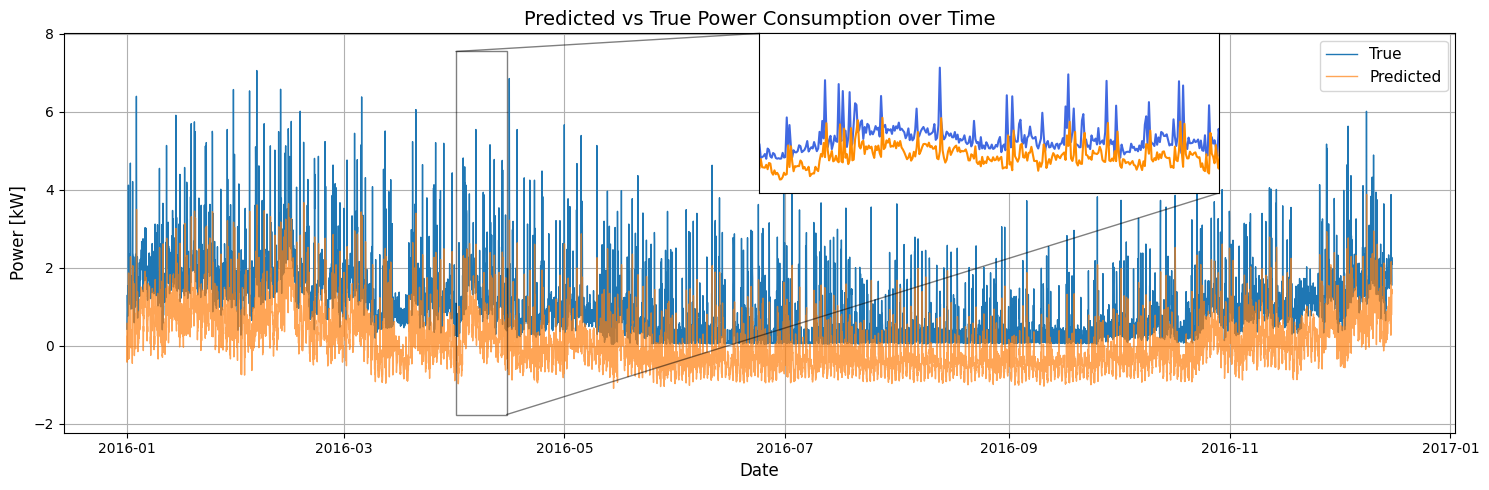

In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib import rcParams
import joblib
from keras.optimizers import Adam
from src.models.lstm_model import LSTMModel
from src.data.data_handler import DataHandler

# === PATHS ===
exp_name       = 'lstm_smartumass_multiappart_lag_temp_cyclical'
base_dir       = os.path.join('D:/Data science/energy-forecasting-ml/outputs', 'experiments_UMass', exp_name)
model_path     = os.path.join(base_dir, 'checkpoints', 'best_lstm_model.keras')
scaler_x_path  = os.path.join(base_dir, 'x_scaler.pkl')
scaler_y_path  = os.path.join(base_dir, 'y_scaler.pkl')
csv_path_test  = 'D:/Data science/energy-forecasting-ml/data/processed/UMass Smart Dataset/test_apartment.csv'

# === COLUMNS ===
date_col      = 'time'
target_col    = 'power [kW]'
feature_cols  = ['power [kW]_lag_1', 'power [kW]_lag_24', 'power [kW]_lag_168', 'temperature',
                 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos']
no_scale_cols = ['hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos']

# === LOAD DATA ===
df_test = pd.read_csv(csv_path_test, parse_dates=[date_col])
X_test_ap = df_test[feature_cols].copy()
y_test_ap = df_test[target_col].values
test_dates = df_test[date_col].reset_index(drop=True)

# === SCALE FEATURES ===
x_scaler = joblib.load(scaler_x_path)
cols_to_scale = [c for c in feature_cols if c not in no_scale_cols]
X_test_ap[cols_to_scale] = x_scaler.transform(X_test_ap[cols_to_scale])

# === RECREATE SCALED TEST SET ===
df_test_scaled = X_test_ap.copy()
df_test_scaled[target_col] = y_test_ap

# === CREATE SEQUENCES ===
dh_test = DataHandler(
    csv_path=csv_path_test,
    date_col=date_col,
    feature_cols=feature_cols,
    target_col=target_col,
    no_scale_cols=no_scale_cols,
    holdout_ratio=0,
    holdout_years=None,
    scaler_type='standard'
)
X_seq_te, X_stat_te, y_te = dh_test.create_sequences(df_test_scaled)

# === LOAD MODEL ===
params = {
    'input_shape_seq': X_seq_te.shape[1:],
    'input_shape_stat': X_stat_te.shape[1] if X_stat_te is not None else 0,
    'lstm_units': 64,
    'dense_units': 256,
    'loss': 'mse',
    'metrics': ['mae'],
    'optimizer': Adam(learning_rate=5e-5),
    'scale_mode': 'standard'
}
lstm_loaded = LSTMModel(params)
lstm_loaded.model.load_weights(model_path)

# === PREDICTIONS ===
y_scaler = joblib.load(scaler_y_path)
lstm_loaded.y_scaler = y_scaler
y_pred_scaled = lstm_loaded.predict({'seq_input': X_seq_te, 'static_input': X_stat_te})
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# === MATCH DATE LENGTH ===
test_dates = test_dates.iloc[-len(y_pred):].reset_index(drop=True)

# === PLOT ===
plt.style.use('default')
rcParams.update({'axes.titlesize': 14, 'axes.labelsize': 12, 'legend.fontsize': 11})
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(test_dates, y_te, label='True', linewidth=1)
ax.plot(test_dates, y_pred, label='Predicted', linewidth=1, alpha=0.7)
ax.set_title('Predicted vs True Power Consumption over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Power [kW]')
ax.legend()
ax.grid(True)
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))

# === ZOOM INSET ===
zoom_start = pd.to_datetime('2016-04-01')
zoom_end   = pd.to_datetime('2016-04-15')
mask_zoom  = (test_dates >= zoom_start) & (test_dates <= zoom_end)

axins = ax.inset_axes([0.5, 0.6, 0.33, 0.4])
axins.plot(test_dates, y_te, color='royalblue')
axins.plot(test_dates, y_pred, color='darkorange')
axins.set_xlim(zoom_start, zoom_end)
axins.set_ylim(min(y_te[mask_zoom]) - 2, max(y_te[mask_zoom]) + 2)
axins.set_xticks([])
axins.set_yticks([])
ax.indicate_inset_zoom(axins, edgecolor="black")

plt.tight_layout()
plt.show()


c:\Users\anton\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


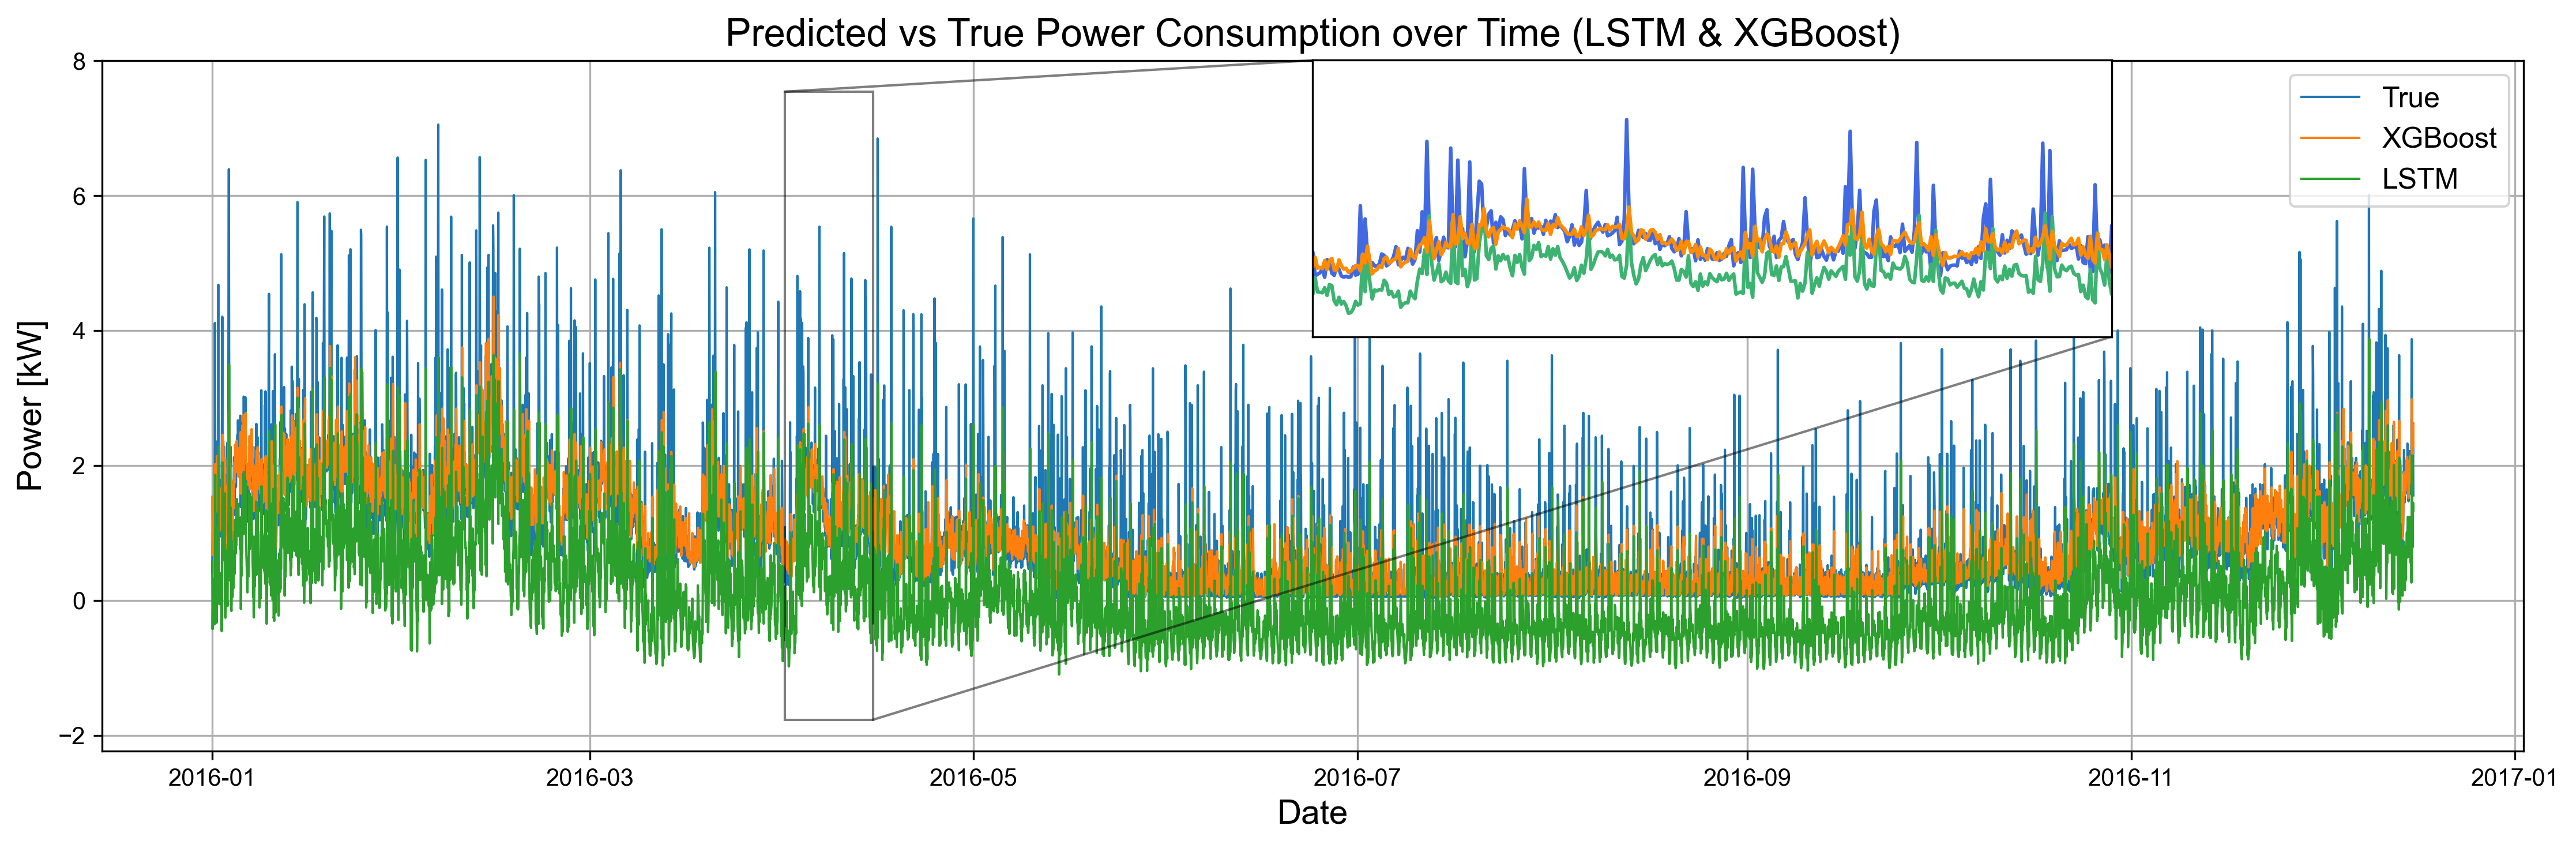

<Figure size 1920x1440 with 0 Axes>

In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib import rcParams
import joblib
import pickle
from keras.optimizers import Adam
from src.models.lstm_model import LSTMModel
from src.data.data_handler import DataHandler

# === PATHS ===
lstm_exp = 'lstm_smartumass_multiappart_lag_temp_cyclical'
xgb_exp  = 'xgboost_smartumass_experiment_multiappart_temp_lag_cyclical'
base_dir_lstm = os.path.join('D:/Data science/energy-forecasting-ml/outputs', 'experiments_UMass', lstm_exp)
base_dir_xgb  = os.path.join('D:/Data science/energy-forecasting-ml/outputs', 'experiments_UMass', xgb_exp)
csv_path_test = 'D:/Data science/energy-forecasting-ml/data/processed/UMass Smart Dataset/test_apartment.csv'

# === COLUMNS ===
date_col = 'time'
target_col = 'power [kW]'
feature_cols = [
    'power [kW]_lag_1', 'power [kW]_lag_24', 'power [kW]_lag_168', 'temperature',
    'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos'
]
no_scale_cols = ['hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos']

# === LOAD TEST DATA ===
df_test = pd.read_csv(csv_path_test, parse_dates=[date_col])
X_test = df_test[feature_cols].copy()
y_true = df_test[target_col].values
test_dates = df_test[date_col].reset_index(drop=True)

# === PREDICTION XGBOOST ===
scaler_x_xgb = joblib.load(os.path.join(base_dir_xgb, 'metrics', 'x_scaler.pkl'))
model_xgb_path = os.path.join(base_dir_xgb, 'metrics', 'best_model.pkl')
cols_to_scale = [c for c in feature_cols if c not in no_scale_cols]
X_test_xgb = X_test.copy()
X_test_xgb[cols_to_scale] = scaler_x_xgb.transform(X_test_xgb[cols_to_scale])
with open(model_xgb_path, 'rb') as f:
    model_xgb = pickle.load(f)
y_pred_xgb = np.expm1(model_xgb.predict(X_test_xgb))

# === PREDICTION LSTM ===
scaler_x_lstm = joblib.load(os.path.join(base_dir_lstm, 'x_scaler.pkl'))
scaler_y_lstm = joblib.load(os.path.join(base_dir_lstm, 'y_scaler.pkl'))
X_test_lstm = X_test.copy()
X_test_lstm[cols_to_scale] = scaler_x_lstm.transform(X_test_lstm[cols_to_scale])
df_test_scaled = X_test_lstm.copy()
df_test_scaled[target_col] = y_true
dh_test = DataHandler(
    csv_path=csv_path_test,
    date_col=date_col,
    feature_cols=feature_cols,
    target_col=target_col,
    no_scale_cols=no_scale_cols,
    holdout_ratio=0,
    holdout_years=None,
    scaler_type='standard'
)
X_seq_te, X_stat_te, y_te = dh_test.create_sequences(df_test_scaled)
params = {
    'input_shape_seq': X_seq_te.shape[1:],
    'input_shape_stat': X_stat_te.shape[1] if X_stat_te is not None else 0,
    'lstm_units': 64,
    'dense_units': 256,
    'loss': 'mse',
    'metrics': ['mae'],
    'optimizer': Adam(learning_rate=5e-5),
    'scale_mode': 'standard'
}
lstm_model = LSTMModel(params)
lstm_model.model.load_weights(os.path.join(base_dir_lstm, 'checkpoints', 'best_lstm_model.keras'))
lstm_model.y_scaler = scaler_y_lstm
y_pred_lstm_scaled = lstm_model.predict({'seq_input': X_seq_te, 'static_input': X_stat_te})
y_pred_lstm = scaler_y_lstm.inverse_transform(y_pred_lstm_scaled.reshape(-1, 1)).ravel()

# === ALIGN DATES ===
test_dates = test_dates.iloc[-len(y_pred_lstm):].reset_index(drop=True)
y_true = y_true[-len(y_pred_lstm):]
y_pred_xgb = y_pred_xgb[-len(y_pred_lstm):]

# === PLOT ===
plt.style.use('default')
rcParams.update({
    'figure.dpi': 300,           # DPI affichage
    'savefig.dpi': 300,          # DPI export
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'lines.linewidth': 1.5,
    'font.family': 'sans-serif',
    'font.sans-serif': 'Arial'
})
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(test_dates, y_true,        label='True',        linewidth=1)
ax.plot(test_dates, y_pred_xgb,  label='XGBoost', linewidth=1)
ax.plot(test_dates, y_pred_lstm, label='LSTM', linewidth=1)
ax.set_title('Predicted vs True Power Consumption over Time (LSTM & XGBoost)')
ax.set_xlabel('Date')
ax.set_ylabel('Power [kW]')
ax.legend(loc='upper right')
ax.grid(True)
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))

# === ZOOM INSET ===
zoom_start = pd.to_datetime('2016-04-01')
zoom_end   = pd.to_datetime('2016-04-15')
mask_zoom  = (test_dates >= zoom_start) & (test_dates <= zoom_end)

axins = ax.inset_axes([0.5, 0.6, 0.33, 0.4])
axins.plot(test_dates, y_true,      color='royalblue', label='True')
axins.plot(test_dates, y_pred_lstm, color='mediumseagreen', label='LSTM')
axins.plot(test_dates, y_pred_xgb,  color='darkorange', label='XGBoost')
axins.set_xlim(zoom_start, zoom_end)
axins.set_ylim(min(y_true[mask_zoom]) - 2, max(y_true[mask_zoom]) + 2)
axins.set_xticks([])
axins.set_yticks([])
ax.indicate_inset_zoom(axins, edgecolor="black")

plt.tight_layout()
plt.show()
plt.savefig(os.path.join(base_dir_lstm, 'metrics', 'predictions_comparison.png'), dpi=300)


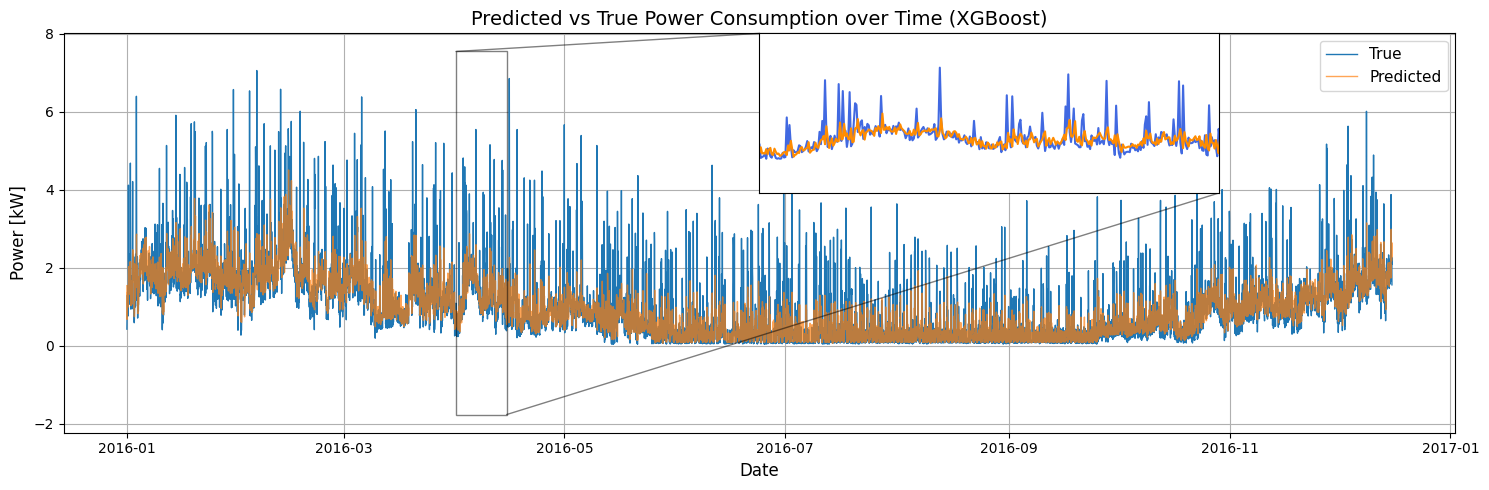

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib import rcParams
import joblib
import pickle

# === PATHS ===
exp_name = 'xgboost_smartumass_experiment_multiappart_temp_lag_cyclical'
base_dir = os.path.join('D:/Data science/energy-forecasting-ml/outputs', 'experiments_UMass', exp_name)
csv_path_test = 'D:/Data science/energy-forecasting-ml/data/processed/UMass Smart Dataset/test_apartment.csv'
scaler_x_path = os.path.join(base_dir, 'metrics', 'x_scaler.pkl')
model_path = os.path.join(base_dir, 'metrics', 'best_model.pkl')

# === COLUMNS ===
date_col = 'time'
target_col = 'power [kW]'
feature_cols = [
    'power [kW]_lag_1',  'power [kW]_lag_24',  'power [kW]_lag_168', 'temperature',
    'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos'
]
no_scale_cols = ['hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos']

# === LOAD TEST DATA ===
df_test = pd.read_csv(csv_path_test, parse_dates=[date_col])
X_test = df_test[feature_cols].copy()
y_true = df_test[target_col].values
test_dates = df_test[date_col].reset_index(drop=True)

# === SCALE X TEST ===
scaler_x = joblib.load(scaler_x_path)
cols_to_scale = [col for col in feature_cols if col not in no_scale_cols]
X_test[cols_to_scale] = scaler_x.transform(X_test[cols_to_scale])

# === LOAD TRAINED XGBOOST MODEL ===
with open(model_path, 'rb') as f:
    model = pickle.load(f)

# === PREDICTION ===
y_pred = model.predict(X_test)
y_pred = np.expm1(y_pred)  # Inverse log1p
y_true = y_true  # y_test was not log1p during testing

# === MATCH DATE LENGTH ===
test_dates = test_dates.iloc[-len(y_pred):].reset_index(drop=True)

# === PLOT ===
plt.style.use('default')
rcParams.update({'axes.titlesize': 14, 'axes.labelsize': 12, 'legend.fontsize': 11})
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(test_dates, y_true, label='True', linewidth=1)
ax.plot(test_dates, y_pred, label='Predicted', linewidth=1, alpha=0.7)
ax.set_title('Predicted vs True Power Consumption over Time (XGBoost)')
ax.set_xlabel('Date')
ax.set_ylabel('Power [kW]')
ax.legend()
ax.grid(True)
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))

# === ZOOM INSET ===
zoom_start = pd.to_datetime('2016-04-01')
zoom_end   = pd.to_datetime('2016-04-15')
mask_zoom  = (test_dates >= zoom_start) & (test_dates <= zoom_end)

axins = ax.inset_axes([0.5, 0.6, 0.33, 0.4])
axins.plot(test_dates, y_true, color='royalblue')
axins.plot(test_dates, y_pred, color='darkorange')
axins.set_xlim(zoom_start, zoom_end)
axins.set_ylim(min(y_true[mask_zoom]) - 2, max(y_true[mask_zoom]) + 2)
axins.set_xticks([])
axins.set_yticks([])
ax.indicate_inset_zoom(axins, edgecolor="black")

plt.tight_layout()
plt.show()


c:\Users\anton\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\anton\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\anton\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\anton\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  

548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


c:\Users\anton\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


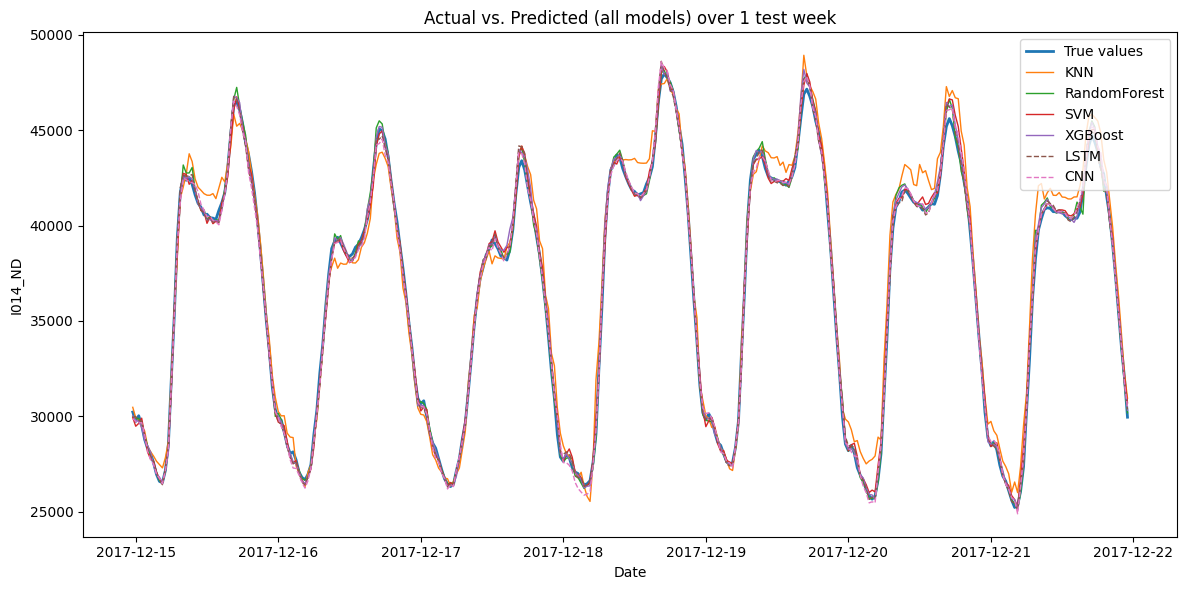

In [ ]:
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from src.data.data_handler import DataHandler
from src.models.lstm_model import LSTMModel
from src.models.cnn_model import CNNModel

# 1) Load test data (last year of the dataset)
csv_path   = 'D:/Data science/energy-forecasting-ml/data/processed/NESO_UK/preprocessed_new_features_cleaned_DemandData_2011-2018.csv'
date_col   = 'datetime'
target_col = 'I014_ND'

# List of all feature columns
feature_cols = [
    'NON_BM_STOR', 'I014_PUMP_STORAGE_PUMPING', 'is_interpolated', 'is_weekend',
    'I014_ND_lag_1', 'I014_ND_lag_2', 'I014_ND_lag_48', 'I014_ND_lag_96', 'I014_ND_lag_336',
    'I014_ND_mean_48', 'I014_ND_mean_336', 'net_import', 'wind_capacity_factor',
    'solar_capacity_factor', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos'
]

# Columns that should not be scaled
no_scale_cols = [
    'is_interpolated', 'is_weekend',
    'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos'
]

# Initialize DataHandler to split out last year as test set
dh = DataHandler(
    csv_path=csv_path,
    date_col=date_col,
    feature_cols=feature_cols,
    target_col=target_col,
    no_scale_cols=no_scale_cols,
    holdout_years=1,         # reserve 1 year for testing
    scaler_type='standard'   # use standard scaling for features
)

# Load full DataFrame, then split into train/validation and test
df_full        = dh.load_data()
df_trainval, df_test = dh.temporal_split(df_full)

# Scale features and extract numpy arrays
X_trval, y_trval, X_test, y_test = dh.scale_split(df_trainval, df_test)

# Extract datetime index for plotting
dates = pd.to_datetime(df_test[date_col])


# 2) Generate predictions for classical ML models

models_info = {
    'KNN': 'D:/Data science/energy-forecasting-ml/outputs/experiments/all_features_std_norm_knn_experiment/metrics/best_model.pkl',
    'RandomForest': 'D:/Data science/energy-forecasting-ml/outputs/experiments/all_features_std_norm_rf_experiment/metrics/best_model.pkl',
    'SVM': 'D:/Data science/energy-forecasting-ml/outputs/experiments/all_features_std_norm_svm_experiment/metrics/best_model.pkl',
    'XGBoost': 'D:/Data science/energy-forecasting-ml/outputs/experiments/all_features_std_norm_xgboost_experiment/metrics/best_model.pkl'
}

preds_classic = {}
for name, path in models_info.items():
    # Load the saved model and predict on the test set
    mdl = joblib.load(path)
    preds_classic[name] = mdl.predict(X_test)


# 3) Prepare sequence inputs and predict with LSTM and CNN

# Re-initialize DataHandler with min-max scaling for sequence models
dh_seq = DataHandler(
    csv_path=csv_path,
    date_col=date_col,
    feature_cols=feature_cols,
    target_col=target_col,
    no_scale_cols=no_scale_cols,
    holdout_years=1,
    scaler_type='minmax'
)

# Extract sequence-structured inputs for LSTM
_, _, _, _, _, _, X_seq_te, X_stat_te, y_seq_te = dh_seq.get_sequence_data(val_years=1)


# --- LSTM Model Prediction ---

lstm_weights_path = 'D:/Data science/energy-forecasting-ml/outputs/experiments/lstm_all_lags_experiment_save1/models/best_lstm.keras'
lstm_scaler_path  = 'D:/Data science/energy-forecasting-ml/outputs/experiments/lstm_all_lags_experiment_save1/y_scaler.pkl'

# Define LSTM architecture parameters
params_lstm = {
    'input_shape_seq': X_seq_te.shape[1:],  # shape of time-series input
    'input_shape_stat': X_stat_te.shape[1], # shape of static input
    'lstm_units': 64,
    'dense_units': 128,
    'loss': 'mse',
    'metrics': ['mae'],
    'optimizer': 'adam',
    'scale_mode': 'standard'
}

# Instantiate and load pre-trained LSTM
lstm = LSTMModel(params_lstm)
lstm.model.load_weights(lstm_weights_path)

# Load Y-scaler to invert scaling on predictions
lstm.y_scaler = joblib.load(lstm_scaler_path)

# Predict and inverse-transform to original scale
y_pred_lstm = lstm.y_scaler.inverse_transform(
    lstm.predict({'seq_input': X_seq_te, 'static_input': X_stat_te}).reshape(-1, 1)
).ravel()


# --- CNN Model Prediction ---

# Re-initialize DataHandler with min-max scaling for sequence models
dh_seq = DataHandler(
    csv_path=csv_path,
    date_col=date_col,
    feature_cols=feature_cols,
    target_col=target_col,
    no_scale_cols=no_scale_cols,
    holdout_years=1,
    scaler_type='standard'  # Use standard scaling for CNN
)

# Extract sequence-structured inputs for LSTM/CNN
_, _, _, _, _, _, X_seq_te, X_stat_te, y_seq_te = dh_seq.get_sequence_data(val_years=1)

cnn_weights_path = 'D:/Data science/energy-forecasting-ml/outputs/experiments/cnn_all_lags_experiment_save1/models/best_cnn.keras'
cnn_scaler_path  = 'D:/Data science/energy-forecasting-ml/outputs/experiments/cnn_all_lags_experiment_save1/y_scaler.pkl'

# Define CNN architecture parameters
params_cnn = {
    'input_shape_seq': X_seq_te.shape[1:],  
    'input_shape_stat': X_stat_te.shape[1],
    'filters': 64,
    'kernel_size': 3,
    'pool_size': 2,
    'dense_units': 128,
    'loss': 'mse',
    'metrics': ['mae'],
    'optimizer': 'adam',
    'scale_mode': 'standard'
}

# Instantiate and load pre-trained CNN
cnn = CNNModel(params_cnn)
cnn.model.load_weights(cnn_weights_path)

# Load Y-scaler for CNN and transform predictions back
cnn.y_scaler = joblib.load(cnn_scaler_path)
y_pred_cnn = cnn.y_scaler.inverse_transform(
    cnn.predict({'seq_input': X_seq_te, 'static_input': X_stat_te}).reshape(-1, 1)
).ravel()


# 4) Select one week from the test set for plotting
start = dates.iloc[0]
mask  = (dates >= start) & (dates < start + pd.Timedelta(days=7))

dates_w    = dates[mask]
y_true_w   = y_test[mask]
preds_cl_w = {name: preds[mask] for name, preds in preds_classic.items()}
y_lstm_w   = y_pred_lstm[mask]
y_cnn_w    = y_pred_cnn[mask]


# 5) Plot true vs. predicted values for all models on the same week
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(dates_w, y_true_w, label='True values', linewidth=2)

# Plot classical model predictions
for name, y_p in preds_cl_w.items():
    plt.plot(dates_w, y_p, label=name, linewidth=1)

# Plot sequence model predictions
plt.plot(dates_w, y_lstm_w, '--', label='LSTM', linewidth=1)
plt.plot(dates_w, y_cnn_w,  '--', label='CNN',  linewidth=1)

plt.xlabel('Date')
plt.ylabel(target_col)
plt.title('Actual vs. Predicted (all models) over 1 test week')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


1. Preparing test data...
   -> Test data ready.

2. Recreating model, loading weights, and loading scaler...


c:\Users\anton\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


   -> Model recreated and assets loaded successfully.

3. Generating predictions on the test set...
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
   -> Inverse transforming predictions to original scale...
   -> Predictions are ready for visualization.

4. Creating and saving prediction visualization...
   -> Prediction visualization saved to: outputs\evaluations\evaluation_lstm_quantile_experiment_bs_32_bidirectional_64_q01-50-99_minmax\lstm_evaluation_plot.png


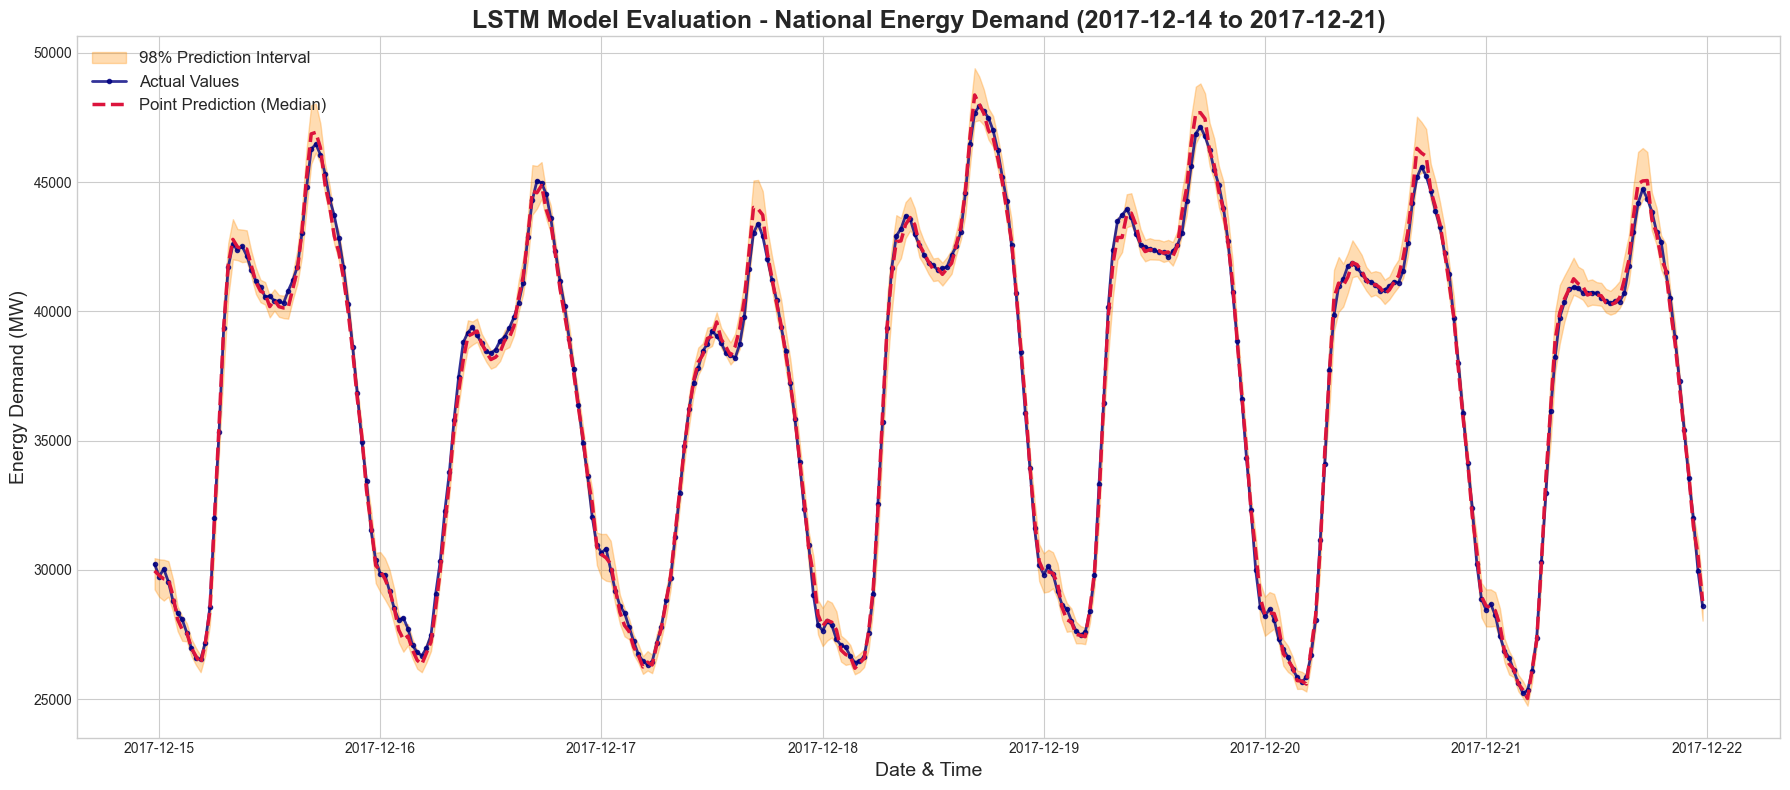

In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

# --- Step 1: Import the necessary model and data classes ---
from src.models.lstm_quantile_model import LSTMQuantileModel, quantile_loss
from src.data.data_handler import DataHandler
from keras.optimizers import Adam


# --- Step 2: Define Paths and Parameters ---
# These must be identical to your training setup
exp_name = 'lstm_quantile_experiment_bs_32_bidirectional_64_q01-50-99_minmax'
base_dir = os.path.join('outputs', 'experiments', exp_name)
model_path = 'D:/Data science/energy-forecasting-ml/outputs/experiments/lstm_quantile_experiment_bs_32_bidirectional_64_q01-50-99_minmax_save/checkpoints/best_lstm_quantile_model.keras'
scaler_path = 'D:/Data science/energy-forecasting-ml/outputs/experiments/lstm_quantile_experiment_bs_32_bidirectional_64_q01-50-99_minmax_save/y_scaler.pkl'
output_dir = os.path.join('outputs', 'evaluations', f'evaluation_{exp_name}')
os.makedirs(output_dir, exist_ok=True)

# Data and model parameters
csv_path = 'D:\\Data science\\energy-forecasting-ml\\data\\processed\\NESO_UK\\preprocessed_new_features_cleaned_DemandData_2011-2018.csv'
date_col = 'datetime'
target_col = 'I014_ND'
quantiles = [0.01, 0.5, 0.99]
feature_cols = [
    'NON_BM_STOR','I014_PUMP_STORAGE_PUMPING','is_interpolated','is_weekend',
    'I014_ND_lag_1','I014_ND_lag_2','I014_ND_lag_48','I014_ND_lag_96','I014_ND_lag_336',
    'I014_ND_mean_48','I014_ND_mean_336','net_import','wind_capacity_factor',
    'solar_capacity_factor','hour_sin','hour_cos','weekday_sin','weekday_cos','month_sin','month_cos'
]
no_scale_cols = [
    'is_interpolated','is_weekend',
    'hour_sin','hour_cos','weekday_sin','weekday_cos','month_sin','month_cos'
]


# --- Step 3: Prepare the Test Data ---
# We do this first to get the data shapes required to build the model
print("1. Preparing test data...")
data_handler = DataHandler(
    csv_path=csv_path, date_col=date_col, feature_cols=feature_cols,
    target_col=target_col, no_scale_cols=no_scale_cols,
    holdout_years=1, scaler_type='minmax'
)
_, _, _, _, _, _, X_seq_te, X_stat_te, y_te = data_handler.get_sequence_data(val_years=1)
X_test_dict = {'seq_input': X_seq_te, 'static_input': X_stat_te}
print("   -> Test data ready.")


# --- Step 4: Recreate Model, Load Weights, and Load Scaler ---
print("\n2. Recreating model, loading weights, and loading scaler...")
try:
    # Define model hyperparameters using the shape of our test data
    params = {
        'input_shape_seq': X_seq_te.shape[1:],
        'input_shape_stat': X_stat_te.shape[1],
        'lstm_units': 64,
        'dense_units': 256,
        'quantiles': quantiles,
    }

    # A) Create a fresh instance of the model architecture
    model_instance = LSTMQuantileModel(params)
    loaded_model = model_instance.model

    # B) Load the saved weights into the newly created model
    loaded_model.load_weights(model_path)

    # C) Load the scaler
    y_scaler = joblib.load(scaler_path)

    print("   -> Model recreated and assets loaded successfully.")

except Exception as e:
    print(f"ERROR: Failed to recreate the model or load assets.")
    print(f"Please check that the model class is available and parameters match training.")
    print(e)
    exit()


# --- Step 5: Generate and Process Predictions ---
print("\n3. Generating predictions on the test set...")
scaled_preds = loaded_model.predict(X_test_dict)
scaled_lower, scaled_median, scaled_upper = scaled_preds[0], scaled_preds[1], scaled_preds[2]

print("   -> Inverse transforming predictions to original scale...")
lower_bound = y_scaler.inverse_transform(scaled_lower).ravel()
median_pred = y_scaler.inverse_transform(scaled_median).ravel()
upper_bound = y_scaler.inverse_transform(scaled_upper).ravel()
print("   -> Predictions are ready for visualization.")


# --- Step 6: Create and Save Prediction Visualization ---
print("\n4. Creating and saving prediction visualization...")
df_full_dates = data_handler.load_data()[[date_col]]
df_test_dates = df_full_dates.iloc[-len(y_te):]
results_df = pd.DataFrame({
    'datetime': df_test_dates[date_col].values,
    'y_true': y_te, 'y_pred': median_pred,
    'lower_bound': lower_bound, 'upper_bound': upper_bound
}).set_index('datetime')

start_date = results_df.index.min()
end_date = start_date + pd.Timedelta(days=7)
results_subset = results_df.loc[start_date:end_date]

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 8))
ax.fill_between(
    results_subset.index, results_subset['lower_bound'], results_subset['upper_bound'],
    color='darkorange', alpha=0.3, label=f'{(quantiles[2] - quantiles[0]) * 100:.0f}% Prediction Interval'
)
ax.plot(
    results_subset.index, results_subset['y_true'], color='navy', linewidth=2,
    marker='o', markersize=3, alpha=0.8, label='Actual Values'
)
ax.plot(
    results_subset.index, results_subset['y_pred'], color='crimson',
    linestyle='--', linewidth=2.5, label='Point Prediction (Median)'
)
ax.set_title(f'LSTM Model Evaluation - National Energy Demand ({start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")})', fontsize=18, fontweight='bold')
ax.set_xlabel('Date & Time', fontsize=14)
ax.set_ylabel('Energy Demand (MW)', fontsize=14)
ax.legend(fontsize=12, loc='upper left')
plt.tight_layout()

output_path = os.path.join(output_dir, 'lstm_evaluation_plot.png')
plt.savefig(output_path, dpi=300)
print(f"   -> Prediction visualization saved to: {output_path}")

plt.show()